## lấy dữ liệu gene

In [ ]:
import pandas as pd
import json

# 1. Đường dẫn tới các file
json_path = '/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/model_fixed_selectkbest/lr_selected_feature_cols.json'
matrix_path = '/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/brca_matrix_with_label_subtyping.tsv'
output_path = '/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/task3_brca_matrix.csv'

# 2. Load danh sách feature từ file JSON
with open(json_path, 'r', encoding='utf-8') as f:
    selected_features = json.load(f)

print(f"Đã nạp {len(selected_features)} features từ file JSON.")

# 3. Chuẩn bị danh sách các cột cần lấy (Feature + File Name)
# Chúng ta đưa "File Name" vào đầu danh sách để dễ quan sát
cols_to_keep = ["File Name"] + selected_features

# 4. Load file matrix và lọc cột
# Sử dụng usecols để chỉ load đúng các cột cần thiết, giúp tiết kiệm RAM
try:
    df_filtered = pd.read_csv(
        matrix_path, 
        sep='\t', 
        usecols=cols_to_keep
    )
    
    # Đảm bảo thứ tự cột đúng như mong muốn: File Name rồi đến các feature
    df_filtered = df_filtered[cols_to_keep]

    print("Đã lọc dữ liệu thành công.")
    print(f"Kích thước ma trận mới: {df_filtered.shape}")
    
    # Hiển thị 5 dòng đầu tiên để kiểm tra
    print("\n5 dòng đầu tiên của dữ liệu đã lọc:")
    print(df_filtered.head())

    # 5. Lưu kết quả ra file mới (tùy chọn)
    df_filtered.to_csv(output_path, index=False)
    print(f"\nKết quả đã được lưu tại: {output_path}")

except ValueError as e:
    print(f"Lỗi: Có một số feature trong file JSON không tồn tại trong file TSV.")
    print(f"Chi tiết lỗi: {e}")
except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file. Hãy kiểm tra lại đường dẫn file.")

## Preprocess

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest

from sksurv.metrics import concordance_index_censored


# ============================================================
# Helpers: IO
# ============================================================
def unify_file_col(df: pd.DataFrame) -> pd.DataFrame:
    """Đảm bảo clinical có cột 'File Name' để merge."""
    df = df.copy()
    if "File Name" not in df.columns and "File_Name" in df.columns:
        df = df.rename(columns={"File_Name": "File Name"})
    return df


def load_and_join(
    matrix_path: str,
    clinical_path: str,
    file_col: str = "File Name",
    time_col: str = "OS_time_days",
    event_col: str = "OS_event",
    sep_gene: str = "\t",
    drop_gene_label_col: str = "label",
) -> tuple[pd.DataFrame, list[str]]:
    """
    Load gene matrix + clinical, merge theo File Name, clean outcome cơ bản.
    Trả về:
      - df: dataframe đã join
      - gene_cols: list gene columns
    """
    # gene
    df_gene = pd.read_csv(matrix_path, sep=sep_gene)
    if drop_gene_label_col in df_gene.columns:
        df_gene = df_gene.drop(columns=[drop_gene_label_col])

    if file_col not in df_gene.columns:
        raise ValueError(f"Không thấy cột '{file_col}' trong gene matrix.")

    df_gene[file_col] = df_gene[file_col].astype(str).str.strip()
    gene_cols = [c for c in df_gene.columns if c != file_col]
    df_gene[gene_cols] = df_gene[gene_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

    min_val = df_gene[gene_cols].to_numpy().min()
    if min_val < 0:
        raise ValueError(f"Gene matrix có giá trị âm (min={min_val}). Log2(1+x) không hợp lệ.")

    # clinical
    df_clin = unify_file_col(pd.read_csv(clinical_path))
    for c in [file_col, time_col, event_col]:
        if c not in df_clin.columns:
            raise ValueError(f"Clinical thiếu cột bắt buộc: {c}")

    df_clin[file_col] = df_clin[file_col].astype(str).str.strip()
    if df_clin[file_col].duplicated().any():
        df_clin = df_clin.drop_duplicates(subset=[file_col], keep="first")

    # join
    df = df_gene.merge(df_clin, on=file_col, how="inner", validate="one_to_one")

    # outcome clean
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[event_col] = pd.to_numeric(df[event_col], errors="coerce")
    df = df.dropna(subset=[time_col, event_col])
    df = df[df[time_col] > 0]
    df[event_col] = df[event_col].astype(int)

    return df, gene_cols


# ============================================================
# Helpers: survival score for SelectKBest
# ============================================================
def _extract_time_event(y):
    # y phải là structured array của sksurv: Surv.from_arrays(...)
    if hasattr(y, "dtype") and y.dtype.names is not None:
        if "time" in y.dtype.names and "event" in y.dtype.names:
            return y["time"].astype(float), y["event"].astype(bool)
    raise ValueError("y phải là Surv.from_arrays(event=..., time=...).")


def cindex_survival_score(X, y):
    """
    Score_func cho SelectKBest (survival):
      score_j = max(ci(x_j), ci(-x_j)) - 0.5   (>=0)
    """
    time, event = _extract_time_event(y)

    if sparse.issparse(X):
        X = X.tocsc()  # lấy cột nhanh

    n_features = X.shape[1]
    scores = np.zeros(n_features, dtype=float)
    pvals = np.full(n_features, np.nan, dtype=float)

    for j in range(n_features):
        if sparse.issparse(X):
            xj = X.getcol(j).toarray().ravel()
        else:
            xj = np.asarray(X[:, j]).ravel()

        xj = np.nan_to_num(xj, nan=0.0, posinf=0.0, neginf=0.0)
        if np.std(xj) == 0:
            scores[j] = 0.0
            continue

        ci1 = concordance_index_censored(event, time, xj)[0]
        ci2 = concordance_index_censored(event, time, -xj)[0]
        scores[j] = max(0.0, max(ci1, ci2) - 0.5)

    return scores, pvals


# ============================================================
# Transformers
# ============================================================
def _log2p(A):
    if sparse.issparse(A):
        B = A.copy()
        B.data = np.log2(B.data + 1.0)
        return B
    return np.log2(A + 1.0)


class TopKVariance(BaseEstimator, TransformerMixin):
    """Giữ k feature có variance lớn nhất (unsupervised)."""
    def __init__(self, k=10000):
        self.k = int(k)
        self.idx_ = None

    def fit(self, X, y=None):
        if sparse.issparse(X):
            Xc = X.tocsc()
            mean = np.array(Xc.mean(axis=0)).ravel()
            mean2 = np.array(Xc.power(2).mean(axis=0)).ravel()
            var = mean2 - mean**2
        else:
            var = np.var(np.asarray(X), axis=0)

        k = min(self.k, var.shape[0])
        self.idx_ = np.argsort(var)[::-1][:k]
        return self

    def transform(self, X):
        if self.idx_ is None:
            raise RuntimeError("TopKVariance chưa fit.")
        return X[:, self.idx_]


class AddOrdinalStageTNM(BaseEstimator, TransformerMixin):
    """
    Thêm các cột ordinal: stage_num/t_num/n_num/m_num + *_unk
    Input/Output: pandas DataFrame
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        def _make(col, mapping, num_col, unk_col):
            if col not in df.columns:
                return
            s = df[col].astype("string").str.strip().str.lower()
            num = s.map(mapping)
            df[num_col] = num.fillna(-1).astype(int)
            df[unk_col] = num.isna().astype(int)

        _make("stage_group", {"i": 1, "ii": 2, "iii": 3, "iv": 4}, "stage_num", "stage_unk")
        _make("ajcc_pathologic_t", {"t1": 1, "t2": 2, "t3": 3, "t4": 4}, "t_num", "t_unk")
        _make("ajcc_pathologic_n", {"n0": 0, "n1": 1, "n2": 2, "n3": 3}, "n_num", "n_unk")
        _make("ajcc_pathologic_m", {"m0": 0, "m1": 1}, "m_num", "m_unk")

        return df


class DenseFloat64(BaseEstimator, TransformerMixin):
    """CoxnetSurvivalAnalysis không nhận sparse => convert sang dense float64."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        return np.asarray(X, dtype=np.float64, order="C")


# ============================================================
# Build preprocess pipelines
# ============================================================
def make_gene_preprocess(var_threshold=0.0, k0_topvar=10000, k_genes=500) -> Pipeline:
    """
    Gene: log2p -> var -> topvar -> scale -> kbest(c-index)
    """
    return Pipeline([
        ("log2p", FunctionTransformer(_log2p, validate=False)),
        ("var", VarianceThreshold(threshold=float(var_threshold))),
        ("topvar", TopKVariance(k=int(k0_topvar))),
        ("scale", MaxAbsScaler()),
        ("kbest", SelectKBest(score_func=cindex_survival_score, k=int(k_genes))),
    ])


def _clinical_column_groups(df_example: pd.DataFrame):
    # one-hot (nominal)
    cat_cols = [
        "race", "ER_status", "PR_status", "HER2_status",
        "laterality", "method_of_diagnosis", "menopause_status",
        "primary_diagnosis_y",
        "stage_sub", "t_suffix", "n_suffix",
    ]

    # numeric scaled (include ordinal nums)
    num_cols = [
        "age_at_diagnosis_years", "lymph_nodes_positive", "lymph_nodes_tested",
        "stage_num", "t_num", "n_num", "m_num",
    ]

    # binary passthrough
    bin_cols = [
        "n_is_mi", "n0_i_plus", "n0_mol_plus", "n_micrometastasis",
        "age_at_diagnosis_years_was_missing",
        "lymph_nodes_positive_was_missing",
        "lymph_nodes_tested_was_missing",
        "stage_unk", "t_unk", "n_unk", "m_unk",
    ]

    cat_cols = [c for c in cat_cols if c in df_example.columns]
    num_cols = [c for c in num_cols if c in df_example.columns]
    bin_cols = [c for c in bin_cols if c in df_example.columns]
    return cat_cols, num_cols, bin_cols


def make_clinical_preprocess(df_example: pd.DataFrame) -> tuple[ColumnTransformer, list[str]]:
    cat_cols, num_cols, bin_cols = _clinical_column_groups(df_example)

    pre_clin = ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]), cat_cols),
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler()),
            ]), num_cols),
            ("bin", "passthrough", bin_cols),
        ],
        remainder="drop"
    )

    use_cols = cat_cols + num_cols + bin_cols
    return pre_clin, use_cols


def make_full_preprocess_pipeline(
    gene_cols: list[str],
    df_example: pd.DataFrame,
    var_threshold=0.0,
    k0_topvar=10000,
    k_genes=500,
) -> Pipeline:
    """
    Full preprocess:
      AddOrdinalStageTNM (DataFrame) ->
      ColumnTransformer( gene pipeline + clinical pipeline ) ->
      DenseFloat64 (để Coxnet fit được)
    """
    gene_pre = make_gene_preprocess(var_threshold, k0_topvar, k_genes)
    clin_pre, clin_use_cols = make_clinical_preprocess(df_example)

    coltf = ColumnTransformer(
        transformers=[
            ("gene", gene_pre, gene_cols),
            ("clin", clin_pre, clin_use_cols),
        ],
        remainder="drop"
    )

    return Pipeline([
        ("ord", AddOrdinalStageTNM()),
        ("features", coltf),
        ("dense", DenseFloat64()),
    ])


## Visualize clinical (raw) & sau preprocessing

Các biểu đồ dưới đây giúp kiểm tra phân bố, thiếu dữ liệu (missing), và mối liên hệ cơ bản với OS.

df_clin shape: (937, 25)


,submitter_id,OS_time_days,OS_event,race,ER_status,PR_status,HER2_status,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_pathologic_n,...,lymph_nodes_positive,lymph_nodes_tested,positive_ratio,menopause_status,tx_surgery_any,tx_radiation_any,tx_chemo_any,tx_hormone_any,File Name,primary_diagnosis_y
0,TCGA-E2-A1IU,337.0,0,white,Positive,Positive,Negative,Stage IA,T1c,N0 (mol+),...,0.0,11.0,0.0,Postmenopausal,1,0,0,1,22c2b380-799e-4fad-ae38-46a916c592d5.rna_seq.a...,Infiltrating duct carcinoma
1,TCGA-AN-A0AM,5.0,0,white,Positive,Negative,Negative,Stage IIA,T2,N0,...,0.0,20.0,0.0,Postmenopausal,1,0,0,0,fd6f4c9b-ee43-4939-8cfa-2e447aedbcf3.rna_seq.a...,Infiltrating duct carcinoma
2,TCGA-A7-A26E,954.0,0,white,Positive,Positive,Negative,Stage IIIA,T3,N1a,...,0.0,16.0,0.0,Postmenopausal,1,1,1,1,a02fb212-a6cc-40b2-9d31-481fc1ce0911.rna_seq.a...,Infiltrating duct carcinoma
3,TCGA-A7-A26E,954.0,0,white,Positive,Positive,Negative,Stage IIIA,T3,N1a,...,0.0,16.0,0.0,Postmenopausal,1,1,1,1,de01516e-43f0-4f96-8ac6-ab543a314829.rna_seq.a...,Infiltrating duct carcinoma
4,TCGA-A7-A26E,954.0,0,white,Positive,Positive,Negative,Stage IIIA,T3,N1a,...,0.0,16.0,0.0,Postmenopausal,1,1,1,1,e6bad6ec-c178-4684-99e8-2504781a022b.rna_seq.a...,Infiltrating duct carcinoma


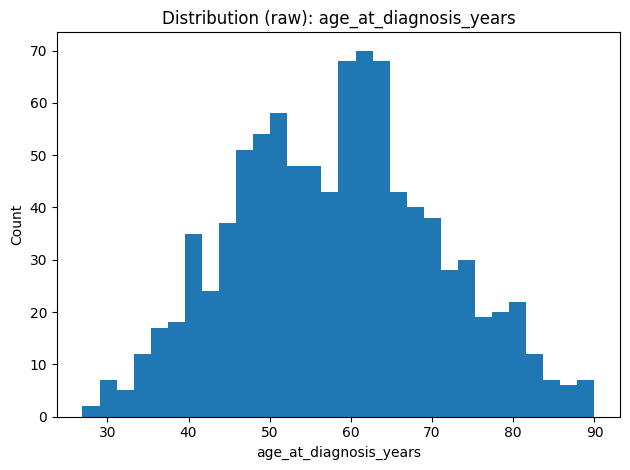

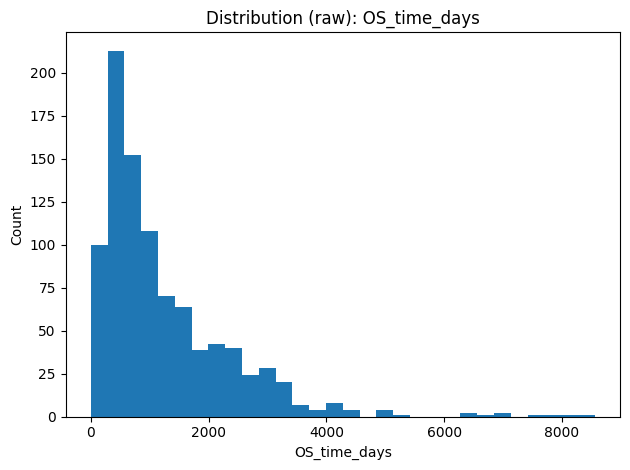

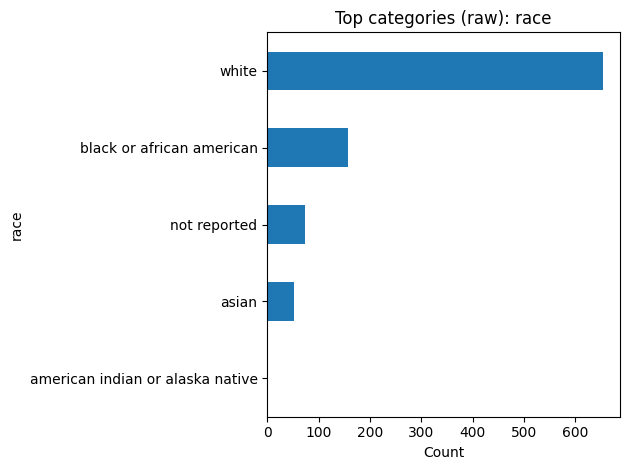

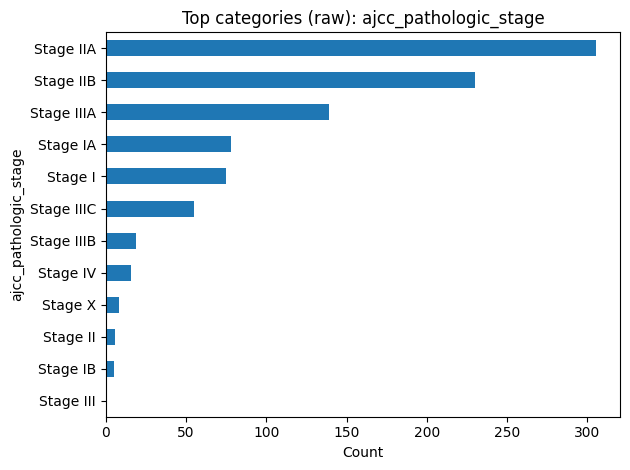

Joined df shape: (937, 516)
Train/Test split sizes: 734 184


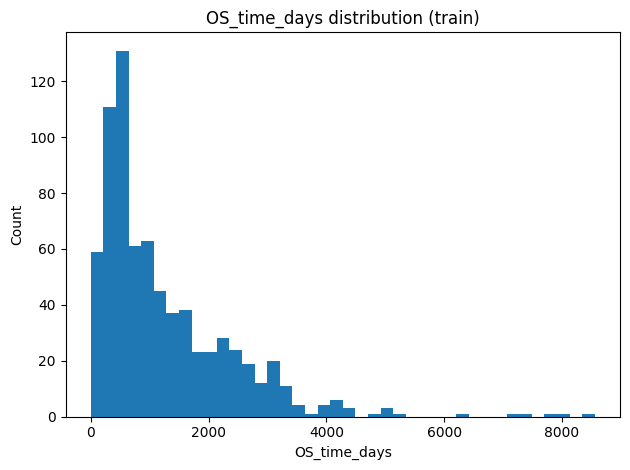

Train event rate: 0.129


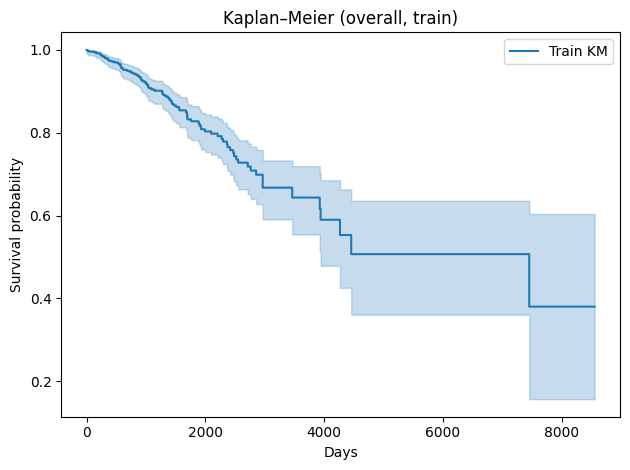

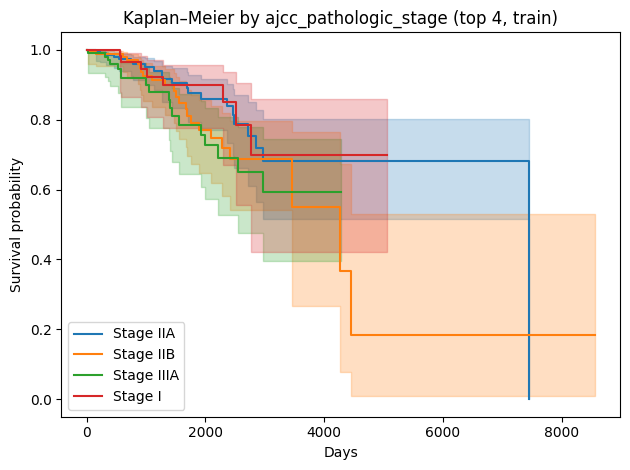

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# =========================
# A) Clinical RAW (df_clin)
# =========================
print("df_clin shape:", df_clin.shape)
display(df_clin.head())

# # 1) Missingness (%)
# miss = (df_clin.isna().mean() * 100).sort_values(ascending=False)
# miss_top = miss.head(25)

# plt.figure()
# miss_top.iloc[::-1].plot(kind="barh")
# plt.xlabel("Missing (%)")
# plt.title("Top clinical columns with missing values (raw)")
# plt.tight_layout()
# plt.show()

# 2) Numeric distributions (raw)
raw_num_cols = [c for c in ["age_at_diagnosis_years","OS_time_days"] if c in df_clin.columns]
for c in raw_num_cols:
    plt.figure()
    s = pd.to_numeric(df_clin[c], errors="coerce")
    s = s[np.isfinite(s)]
    plt.hist(s, bins=30)
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.title(f"Distribution (raw): {c}")
    plt.tight_layout()
    plt.show()

# 3) Categorical distributions (raw)
raw_cat_cols = [c for c in ["race","ajcc_pathologic_stage",] if c in df_clin.columns]
for c in raw_cat_cols:
    plt.figure()
    vc = df_clin[c].astype("string").fillna("NA").value_counts().head(12)
    vc.iloc[::-1].plot(kind="barh")
    plt.xlabel("Count")
    plt.title(f"Top categories (raw): {c}")
    plt.tight_layout()
    plt.show()


# ====================================
# B) Sau join + preprocessing (df, df_train)
# ====================================
print("Joined df shape:", df.shape)
print("Train/Test split sizes:", len(df_train), len(df_test))

# 4) Outcome overview (train)
plt.figure()
plt.hist(df_train["OS_time_days"], bins=40)
plt.xlabel("OS_time_days")
plt.ylabel("Count")
plt.title("OS_time_days distribution (train)")
plt.tight_layout()
plt.show()

event_rate = df_train["OS_event"].mean()
print(f"Train event rate: {event_rate:.3f}")

# 5) Kaplan-Meier overall (train)
kmf = KaplanMeierFitter()
T = df_train["OS_time_days"].values
E = df_train["OS_event"].values
kmf.fit(T, event_observed=E, label="Train KM")
plt.figure()
kmf.plot()
plt.title("Kaplan–Meier (overall, train)")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.tight_layout()
plt.show()

# 6) KM by a common clinical factor (if present): ajcc_pathologic_stage
if "ajcc_pathologic_stage" in df_train.columns:
    stage = df_train["ajcc_pathologic_stage"].astype("string").fillna("NA")
    # Keep top stages by frequency to avoid clutter
    top_stages = stage.value_counts().head(4).index.tolist()
    plt.figure()
    for st in top_stages:
        mask = (stage == st).values
        if mask.sum() < 10:
            continue
        kmf.fit(T[mask], event_observed=E[mask], label=str(st))
        kmf.plot()
    plt.title("Kaplan–Meier by ajcc_pathologic_stage (top 4, train)")
    plt.xlabel("Days")
    plt.ylabel("Survival probability")
    plt.tight_layout()
    plt.show()


## Huấn luyện cox

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test


# ============================================================
# PATH / COLS
# ============================================================
MATRIX_PATH   = "/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/brca_matrix_with_label_subtyping.tsv"
CLINICAL_PATH = "/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/clinical_features_cleaned.csv"

TIME_COL  = "OS_time_days"
EVENT_COL = "OS_event"
FILE_COL  = "File Name"


# ============================================================
# 1) Wrapper: lifelines CoxPHFitter -> sklearn-style estimator
# ============================================================
class CoxPHSklearn(BaseEstimator):
    """
    Sklearn-compatible wrapper cho lifelines.CoxPHFitter
    - fit(X, y_surv): y_surv là Surv structured array (sksurv)
    - predict(X): trả risk score 1D (partial hazard)
    """
    def __init__(self, penalizer=0.1, l1_ratio=0.0):
        self.penalizer = float(penalizer)
        self.l1_ratio = float(l1_ratio)

        self.model_ = None
        self.feature_names_ = None

    @staticmethod
    def _to_dense(X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        return np.asarray(X, dtype=np.float64, order="C")

    def fit(self, X, y):
        Xd = self._to_dense(X)

        # y: Surv structured array
        t = y["time"].astype(float)
        e = y["event"].astype(bool).astype(int)

        # tạo dataframe cho lifelines
        p = Xd.shape[1]
        self.feature_names_ = [f"x{i}" for i in range(p)]
        df_fit = pd.DataFrame(Xd, columns=self.feature_names_)
        df_fit[TIME_COL] = t
        df_fit[EVENT_COL] = e

        # lifelines CoxPH
        self.model_ = CoxPHFitter(penalizer=self.penalizer, l1_ratio=self.l1_ratio)
        self.model_.fit(df_fit, duration_col=TIME_COL, event_col=EVENT_COL)

        return self

    def predict(self, X):
        if self.model_ is None:
            raise RuntimeError("Model chưa fit.")

        Xd = self._to_dense(X)
        dfX = pd.DataFrame(Xd, columns=self.feature_names_)

        # risk score: partial hazard (lớn hơn => nguy cơ cao hơn)
        risk = self.model_.predict_partial_hazard(dfX).to_numpy().ravel()
        return risk


# ============================================================
# 2) Custom scorer: C-index (an toàn về dấu)
# ============================================================
def cindex_scorer(estimator, X, y):
    """
    estimator: pipeline(preprocess + CoxPHSklearn)
    X: df raw
    y: Surv structured array
    """
    pred = estimator.predict(X)  # CoxPH => (n,)
    e = y["event"].astype(bool)
    t = y["time"].astype(float)

    # an toàn dấu: thử cả pred và -pred
    ci1 = concordance_index_censored(e, t, pred)[0]
    ci2 = concordance_index_censored(e, t, -pred)[0]
    return float(max(ci1, ci2))


# ============================================================
# 3) Load + Join
# ============================================================
df, gene_cols = load_and_join(
    matrix_path=MATRIX_PATH,
    clinical_path=CLINICAL_PATH,
    file_col=FILE_COL,
    time_col=TIME_COL,
    event_col=EVENT_COL,
    sep_gene="\t",
)

print("Joined df:", df.shape, "| n_genes:", len(gene_cols))


# ============================================================
# 4) Holdout split (train/test)
# ============================================================
y_event = df[EVENT_COL].astype(int).to_numpy()
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=y_event if np.unique(y_event).size > 1 else None
)

y_train = Surv.from_arrays(
    event=df_train[EVENT_COL].astype(bool).to_numpy(),
    time=df_train[TIME_COL].astype(float).to_numpy(),
)
y_test = Surv.from_arrays(
    event=df_test[EVENT_COL].astype(bool).to_numpy(),
    time=df_test[TIME_COL].astype(float).to_numpy(),
)

print("Train:", df_train.shape, "Test:", df_test.shape,
      "| events_train:", int(df_train[EVENT_COL].sum()),
      "| events_test:", int(df_test[EVENT_COL].sum()))

Joined df: (918, 60689) | n_genes: 60660
Train: (734, 60689) Test: (184, 60689) | events_train: 95 | events_test: 24


In [4]:



# ============================================================
# 5) CONFIG: tune KBest(k)
# ============================================================
VAR_THRESHOLD = 0.95
K0_TOPVAR = 10000
K_LIST = [10, 50, 100, 300, 500, 600]

# CoxPH penalizer (khuyến nghị >0 để ổn định)
PENALIZER = 0.1
L1_RATIO = 0.0

CV_SPLITS = 5


# ============================================================
# 6) Build pipeline: preprocess + CoxPH
# ============================================================
preprocess = make_full_preprocess_pipeline(
    gene_cols=gene_cols,
    df_example=df_train,
    var_threshold=VAR_THRESHOLD,
    k0_topvar=K0_TOPVAR,
    k_genes=K_LIST[0],  # placeholder; sẽ tune bằng GridSearch
)

coxph = CoxPHSklearn(penalizer=PENALIZER, l1_ratio=L1_RATIO)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", coxph),
])


# ============================================================
# 7) CV tune SelectKBest(k) (KHÔNG nested)
# ============================================================
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=42)
y_strat = df_train[EVENT_COL].astype(int).to_numpy()

param_grid = {
    "prep__features__gene__kbest__k": K_LIST,
}

gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv.split(df_train, y_strat),
    scoring=cindex_scorer,
    n_jobs=1,
    refit=True,
    verbose=2,
)

gcv.fit(df_train, y_train)

print("\n===== BEST (CV) =====")
print("best_params:", gcv.best_params_)
print("best_cv_cindex:", float(gcv.best_score_))

best_pipe = gcv.best_estimator_


# ============================================================
# 8) Evaluate on TEST holdout
# ============================================================
risk_test = best_pipe.predict(df_test)
e = y_test["event"].astype(bool)
t = y_test["time"].astype(float)

ci1 = concordance_index_censored(e, t, risk_test)[0]
ci2 = concordance_index_censored(e, t, -risk_test)[0]
test_cindex = float(max(ci1, ci2))

print("\n===== TEST =====")
print("test_cindex:", test_cindex)





Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  25.4s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['x57'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column x30 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_event'].astype(bool)
>>> print(df.loc[events, 'x30'].var())
>>> print(df.loc[~event

[CV] END ..................prep__features__gene__kbest__k=10; total time=  24.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  25.6s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  26.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  25.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  25.5s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['x97'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column x70 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_event'].astype(bool)
>>> print(df.loc[events, 'x70'].var())
>>> print(df.loc[~event

[CV] END ..................prep__features__gene__kbest__k=50; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  25.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  26.2s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  26.2s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  25.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['x147'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column x120 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_event'].astype(bool)
>>> print(df.loc[events, 'x120'].var())
>>> print(df.loc[~ev

[CV] END .................prep__features__gene__kbest__k=100; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  25.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  26.3s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  26.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  27.2s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['x347'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column x320 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_event'].astype(bool)
>>> print(df.loc[events, 'x320'].var())
>>> print(df.loc[~ev

[CV] END .................prep__features__gene__kbest__k=300; total time=  25.5s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  27.3s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  27.7s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  27.5s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  30.3s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['x547'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column x520 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_event'].astype(bool)
>>> print(df.loc[events, 'x520'].var())
>>> print(df.loc[~ev

[CV] END .................prep__features__gene__kbest__k=500; total time=  25.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  29.7s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  34.6s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  29.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  36.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['x647'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning:

[CV] END .................prep__features__gene__kbest__k=600; total time=  26.7s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  32.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  34.5s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/lifelines/fitters/coxph_fitter.py", line 

[CV] END .................prep__features__gene__kbest__k=600; total time=  31.6s

===== BEST (CV) =====
best_params: {'prep__features__gene__kbest__k': 10}
best_cv_cindex: nan

===== TEST =====
test_cindex: 0.7885888945491595


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Thresholds (train tertiles): t1= 0.7051912903053119  t2= 1.3092324847750025
Test label counts: {'MED': 70, 'HIGH': 57, 'LOW': 57}


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


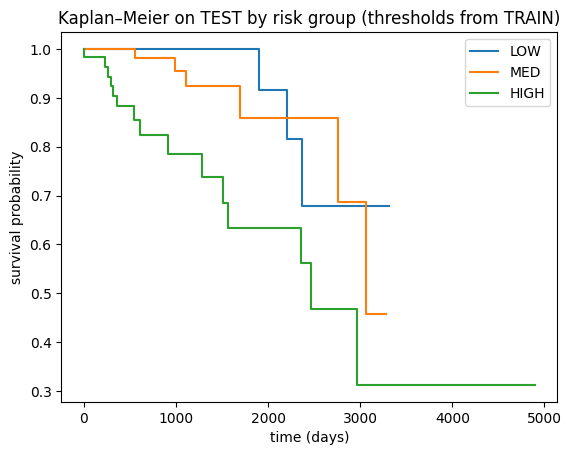

Log-rank (HIGH vs LOW) p-value: 0.0032789070093400758
Saved artifact -> coxph_streamlit_artifact.joblib


In [6]:
# ============================================================
# 9) KM + Log-rank (LOW/MED/HIGH theo TRAIN tertiles)
# ============================================================
risk_train = best_pipe.predict(df_train)

t1, t2 = np.percentile(risk_train, [33, 66])
print("Thresholds (train tertiles): t1=", float(t1), " t2=", float(t2))

def risk_to_label(r, t1, t2):
    r = np.asarray(r).ravel()
    return np.where(r <= t1, "LOW", np.where(r <= t2, "MED", "HIGH"))

labels_test = risk_to_label(risk_test, t1, t2)
print("Test label counts:", pd.Series(labels_test).value_counts().to_dict())

df_km = pd.DataFrame({
    "time": df_test[TIME_COL].astype(float).to_numpy(),
    "event": df_test[EVENT_COL].astype(int).to_numpy(),
    "group": labels_test
})

plt.figure()
kmf = KaplanMeierFitter()
for g in ["LOW", "MED", "HIGH"]:
    m = df_km["group"] == g
    if m.sum() == 0:
        continue
    kmf.fit(df_km.loc[m, "time"], event_observed=df_km.loc[m, "event"], label=g)
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier on TEST by risk group (thresholds from TRAIN)")
plt.xlabel("time (days)")
plt.ylabel("survival probability")
plt.show()

m_hi = df_km["group"] == "HIGH"
m_lo = df_km["group"] == "LOW"
if m_hi.sum() > 0 and m_lo.sum() > 0:
    lr = logrank_test(
        df_km.loc[m_hi, "time"], df_km.loc[m_lo, "time"],
        event_observed_A=df_km.loc[m_hi, "event"],
        event_observed_B=df_km.loc[m_lo, "event"]
    )
    print("Log-rank (HIGH vs LOW) p-value:", float(lr.p_value))


# ============================================================
# 10) Save artifact for Streamlit
# ============================================================
ARTIFACT_PATH = "coxph_streamlit_artifact.joblib"

artifact = {
    "pipeline": best_pipe,   # preprocess + CoxPHSklearn (bọc lifelines)
    "t1": float(t1),
    "t2": float(t2),

    "time_col": TIME_COL,
    "event_col": EVENT_COL,
    "file_col": FILE_COL,

    "best_params": gcv.best_params_,
    "best_cv_cindex": float(gcv.best_score_),
    "test_cindex": float(test_cindex),

    # để bạn biết penalizer dùng bao nhiêu
    "coxph_penalizer": float(PENALIZER),
    "coxph_l1_ratio": float(L1_RATIO),
}

joblib.dump(artifact, ARTIFACT_PATH)
print("Saved artifact ->", ARTIFACT_PATH)

## Huấn luyện CoxnetSurvivalAnalysis

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxnetSurvivalAnalysis


MATRIX_PATH   = "/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/brca_matrix_with_label_subtyping.tsv"
CLINICAL_PATH = "/home/uit2023/LuuTru/Thuchd/cs313/CS331/run_model/clinical_features_cleaned.csv"

TIME_COL  = "OS_time_days"
EVENT_COL = "OS_event"
FILE_COL  = "File Name"

# ============================================================
# Custom scorer: C-index (an toàn về dấu)
# ============================================================
def cindex_scorer(estimator, X, y):
    """
    estimator: pipeline(preprocess + Coxnet)
    X: df raw (DataFrame)
    y: Surv structured array
    """
    pred = estimator.predict(X)
    # pred có thể (n,) hoặc (n, n_alphas). Nếu nhiều alpha -> lấy alpha tốt nhất trên fold
    if pred.ndim == 2:
        # chọn best alpha trong fold theo CI
        e = y["event"].astype(bool)
        t = y["time"].astype(float)
        cis = []
        for j in range(pred.shape[1]):
            s = pred[:, j]
            ci1 = concordance_index_censored(e, t, s)[0]
            ci2 = concordance_index_censored(e, t, -s)[0]
            cis.append(max(ci1, ci2))
        return float(np.max(cis))

    e = y["event"].astype(bool)
    t = y["time"].astype(float)
    ci1 = concordance_index_censored(e, t, pred)[0]
    ci2 = concordance_index_censored(e, t, -pred)[0]
    return float(max(ci1, ci2))


# ============================================================
# 1) Load + Join
# ============================================================
df, gene_cols = load_and_join(
    matrix_path=MATRIX_PATH,
    clinical_path=CLINICAL_PATH,
    file_col=FILE_COL,
    time_col=TIME_COL,
    event_col=EVENT_COL,
    sep_gene="\t",
)

print("Joined df:", df.shape, "| n_genes:", len(gene_cols))

# ============================================================
# 2) Holdout split (train/test)
# ============================================================
y_event = df[EVENT_COL].astype(int).to_numpy()
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=y_event if np.unique(y_event).size > 1 else None
)

y_train = Surv.from_arrays(
    event=df_train[EVENT_COL].astype(bool).to_numpy(),
    time=df_train[TIME_COL].astype(float).to_numpy(),
)
y_test = Surv.from_arrays(
    event=df_test[EVENT_COL].astype(bool).to_numpy(),
    time=df_test[TIME_COL].astype(float).to_numpy(),
)

print("Train:", df_train.shape, "Test:", df_test.shape,
      "| events_train:", int(df_train[EVENT_COL].sum()),
      "| events_test:", int(df_test[EVENT_COL].sum()))

Joined df: (918, 60689) | n_genes: 60660
Train: (734, 60689) Test: (184, 60689) | events_train: 95 | events_test: 24


In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxnetSurvivalAnalysis



# ============================================================
# CONFIG
# ============================================================


# Gene reduction (2 tầng)
VAR_THRESHOLD = 0.95
K0_TOPVAR = 10000         # giảm nhanh 60k -> 1000
K_LIST   = [10,50,100,300,500,600] # tune SelectKBest k

# Coxnet config (giữ cố định trước, bạn có thể tune sau)
L1_RATIO = 0.5
N_ALPHAS = 100
ALPHA_MIN_RATIO = 0.1
MAX_ITER = 100000

# CV
CV_SPLITS = 5





# ============================================================
# 3) Build pipeline: preprocess + Coxnet
# ============================================================
preprocess = make_full_preprocess_pipeline(
    gene_cols=gene_cols,
    df_example=df_train,  # để lấy đúng clinical cols hiện có
    var_threshold=VAR_THRESHOLD,
    k0_topvar=K0_TOPVAR,
    k_genes=K_LIST[0],    # tạm, sẽ tune bằng GridSearch
)

coxnet = CoxnetSurvivalAnalysis(
    l1_ratio=L1_RATIO,
    n_alphas=N_ALPHAS,
    alpha_min_ratio=ALPHA_MIN_RATIO,
    max_iter=MAX_ITER,
)

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("prep", preprocess),
    ("model", coxnet),
])

# ============================================================
# 4) CV tune SelectKBest(k) (KHÔNG nested)
# ============================================================
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=42)
y_strat = df_train[EVENT_COL].astype(int).to_numpy()

param_grid = {
    "prep__features__gene__kbest__k": K_LIST,
}

gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv.split(df_train, y_strat),
    scoring=cindex_scorer,
    n_jobs=1,
    refit=True,
    verbose=2,
)

gcv.fit(df_train, y_train)

print("\n===== BEST (CV) =====")
print("best_params:", gcv.best_params_)
print("best_cv_cindex:", float(gcv.best_score_))

best_pipe = gcv.best_estimator_

# ============================================================
# 5) Evaluate on TEST holdout
# ============================================================
pred_te = best_pipe.predict(df_test)
e = y_test["event"].astype(bool)
t = y_test["time"].astype(float)

if pred_te.ndim == 2:
    cis = []
    for j in range(pred_te.shape[1]):
        s = pred_te[:, j]
        ci1 = concordance_index_censored(e, t, s)[0]
        ci2 = concordance_index_censored(e, t, -s)[0]
        cis.append(max(ci1, ci2))
    test_cindex = float(np.max(cis))
else:
    ci1 = concordance_index_censored(e, t, pred_te)[0]
    ci2 = concordance_index_censored(e, t, -pred_te)[0]
    test_cindex = float(max(ci1, ci2))

print("\n===== TEST =====")
print("test_cindex:", test_cindex)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  24.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  24.2s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  24.6s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=10; total time=  24.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  24.3s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  24.7s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  25.2s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END ..................prep__features__gene__kbest__k=50; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  24.6s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  24.3s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  24.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=100; total time=  24.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  24.6s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  24.5s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  24.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=300; total time=  25.0s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  24.9s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  24.4s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  24.7s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  25.6s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=500; total time=  25.1s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  24.7s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  24.4s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  24.8s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  25.3s


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END .................prep__features__gene__kbest__k=600; total time=  25.1s

===== BEST (CV) =====
best_params: {'prep__features__gene__kbest__k': 300}
best_cv_cindex: 0.6982281178360745

===== TEST =====
test_cindex: 0.7697401935812532


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[RISK] Using single-alpha prediction. alpha=0.10629481312577606
Thresholds (train tertiles): t1= -0.2907554208913347  t2= 0.20967337400076275
Test label counts: {'MED': 65, 'HIGH': 60, 'LOW': 59}


/home/uit2023/miniconda3/envs/downloadData/lib/python3.14/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


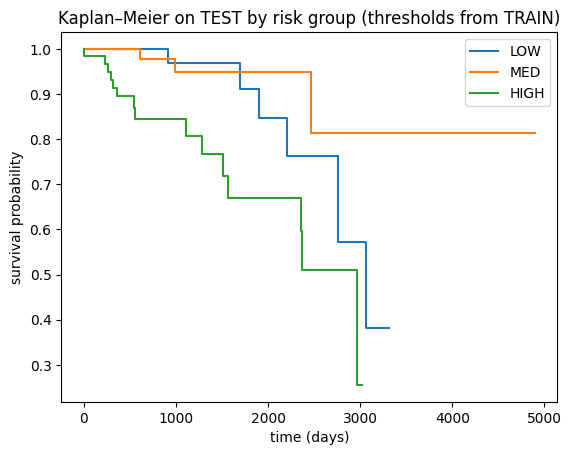

Log-rank (HIGH vs LOW) p-value: 0.011422181835378466
Saved artifact -> coxnet_streamlit_artifact.joblib


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sksurv.metrics import concordance_index_censored

# =========================
# Helper: chọn 1 alpha index tốt nhất cho 1 dataset
# =========================
def pick_best_alpha_idx(y_surv, pred_2d):
    """
    y_surv: Surv structured array
    pred_2d: (n, n_alphas)
    return: best_alpha_idx (int), best_cindex (float)
    """
    e = y_surv["event"].astype(bool)
    t = y_surv["time"].astype(float)

    cis = []
    for j in range(pred_2d.shape[1]):
        s = pred_2d[:, j]
        ci1 = concordance_index_censored(e, t, s)[0]
        ci2 = concordance_index_censored(e, t, -s)[0]
        cis.append(max(ci1, ci2))
    cis = np.asarray(cis, dtype=float)
    jbest = int(np.argmax(cis))
    return jbest, float(cis[jbest])

# =========================
# 6) Risk score on TRAIN/TEST (từ best_pipe)
# =========================
pred_tr = best_pipe.predict(df_train)
pred_te = best_pipe.predict(df_test)

# Nếu model trả (n, n_alphas) => chọn 1 alpha cố định dựa trên TRAIN
if pred_tr.ndim == 2:
    best_alpha_idx, best_train_ci = pick_best_alpha_idx(y_train, pred_tr)
    risk_train = pred_tr[:, best_alpha_idx]
    risk_test  = pred_te[:, best_alpha_idx]
    used_alpha = float(best_pipe.named_steps["model"].alphas_[best_alpha_idx])
    print(f"[RISK] Using alpha_idx={best_alpha_idx} | alpha={used_alpha:.6g} | train_ci={best_train_ci:.4f}")
else:
    # chỉ có 1 alpha
    risk_train = pred_tr
    risk_test  = pred_te
    best_alpha_idx = 0
    used_alpha = float(best_pipe.named_steps["model"].alphas_[0]) if hasattr(best_pipe.named_steps["model"], "alphas_") else np.nan
    print(f"[RISK] Using single-alpha prediction. alpha={used_alpha}")

risk_train = np.asarray(risk_train).ravel()
risk_test  = np.asarray(risk_test).ravel()

# =========================
# 7) LOW/MED/HIGH thresholds (TRAIN tertiles)
# =========================
t1, t2 = np.percentile(risk_train, [33, 66])
print("Thresholds (train tertiles): t1=", float(t1), " t2=", float(t2))

def risk_to_label(r, t1, t2):
    r = np.asarray(r).ravel()
    return np.where(r <= t1, "LOW", np.where(r <= t2, "MED", "HIGH"))

labels_test = risk_to_label(risk_test, t1, t2)
print("Test label counts:", pd.Series(labels_test).value_counts().to_dict())

# =========================
# 8) KM plot (TEST)
# =========================
df_km = pd.DataFrame({
    "time": df_test[TIME_COL].astype(float).to_numpy(),
    "event": df_test[EVENT_COL].astype(int).to_numpy(),
    "group": labels_test
})

plt.figure()
kmf = KaplanMeierFitter()
for g in ["LOW", "MED", "HIGH"]:
    m = df_km["group"] == g
    if m.sum() == 0:
        continue
    kmf.fit(df_km.loc[m, "time"], event_observed=df_km.loc[m, "event"], label=g)
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier on TEST by risk group (thresholds from TRAIN)")
plt.xlabel("time (days)")
plt.ylabel("survival probability")
plt.show()

# log-rank HIGH vs LOW
m_hi = df_km["group"] == "HIGH"
m_lo = df_km["group"] == "LOW"
if m_hi.sum() > 0 and m_lo.sum() > 0:
    lr = logrank_test(
        df_km.loc[m_hi, "time"], df_km.loc[m_lo, "time"],
        event_observed_A=df_km.loc[m_hi, "event"],
        event_observed_B=df_km.loc[m_lo, "event"]
    )
    print("Log-rank (HIGH vs LOW) p-value:", float(lr.p_value))

# =========================
# 9) SAVE ARTIFACT (khuyến nghị lưu pipeline)
# =========================
ARTIFACT_PATH = "coxnet_streamlit_artifact.joblib"

artifact = {
    # lưu pipeline end-to-end: preprocess + coxnet
    "pipeline": best_pipe,

    # thresholds để phân nhóm risk
    "t1": float(t1),
    "t2": float(t2),

    # alpha được chọn để suy luận 1 chiều
    "alpha_idx": int(best_alpha_idx),
    "alpha_value": float(used_alpha),

    # metadata
    "time_col": TIME_COL,
    "event_col": EVENT_COL,
    "file_col": FILE_COL,

    # best CV info
    "best_params": gcv.best_params_,
    "best_cv_cindex": float(gcv.best_score_),

    # NOTE: Coxnet trong scikit-survival có thể yêu cầu dense tùy version/env
    "requires_dense_X": False,   # pipeline của bạn đang nhận df raw, preprocess bên trong
}

joblib.dump(artifact, ARTIFACT_PATH)
print("Saved artifact ->", ARTIFACT_PATH)


## Test cho 1 bệnh nhân cụ thể